In [57]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
import ast

## 1. Create Features

In [96]:
#open desired match dataset as dataframe
match_id = 3754039
matches_file = f"event_data/{match_id}.json"
with open(matches_file, 'r') as file:
    data = json.load(file)
df_matches = pd.json_normalize(data)
df_matches.set_index('index')

# read in json file for entire competition (all matches)
with open("matches_2_27.json", 'r') as competition_file:
    competition_data = json.load(competition_file)
df_competition = pd.json_normalize(competition_data)
df_competition.set_index('match_id', inplace=True)
df_competition.sort_index(inplace=True)

#identify home team and away team
home_team = df_competition.loc[match_id,'home_team.home_team_name']
away_team = df_competition.loc[match_id,'away_team.away_team_name']

#identify home or away possession
df_matches['home_possession'] = df_matches.apply(lambda row: True if getattr(row,'possession_team.name') ==home_team else False, axis=1)

- Define 'A Single Observation': 
    - a. An event-level observation (each event is a row, labeled with time to next goal)
    - b. a window-based observation (aggregate features over X seconds or Y evernts) -- this method would need more match data

- Short-Term Pipeline:
    - keep useful columns
    - encode/engineer the columns.


In [80]:
# df_matches[ 'pass.end_location'][4]
df_matches['tactics.lineup'][0]

[{'player': {'id': 3488, 'name': 'Wayne Hennessey'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'jersey_number': 13},
 {'player': {'id': 3443, 'name': 'Joel Ward'},
  'position': {'id': 2, 'name': 'Right Back'},
  'jersey_number': 2},
 {'player': {'id': 3407, 'name': 'Scott Dann'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'jersey_number': 6},
 {'player': {'id': 3693, 'name': 'Damien Delaney'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'jersey_number': 27},
 {'player': {'id': 4884, 'name': "Pape N''Diaye SouarÃ©"},
  'position': {'id': 6, 'name': 'Left Back'},
  'jersey_number': 23},
 {'player': {'id': 5489, 'name': 'Mile Jedinak'},
  'position': {'id': 10, 'name': 'Center Defensive Midfield'},
  'jersey_number': 15},
 {'player': {'id': 3507, 'name': 'Wilfried Zaha'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'jersey_number': 11},
 {'player': {'id': 3277, 'name': 'Yohan Cabaye'},
  'position': {'id': 13, 'name': 'Right Center Midfield'},
  '

In [97]:
def get_field_third(end_location):
    if not isinstance(end_location, list) or len(end_location) != 2:
        return np.nan  # Handle missing or invalid entries
    x = end_location[0]
    if x < 40:
        return 0 #Left'
    elif x < 80:
        return 1 #'Middle'
    else:
        return 2 #'Right'

df_matches['pass.end_third'] = df_matches['pass.end_location'].apply(get_field_third)

In [98]:
#Calculate cumulative possession time and event time (s)
df = df_matches.copy()

# Compute event time in seconds
df['event_time'] = df['minute'] * 60 + df['second']
# Compute time delta between current and next row
df['time_delta'] = df['event_time'].shift(-1) - df['event_time']
# For the last row, set delta to 0
df['time_delta'] = df['time_delta'].fillna(0)

# Initialize cumulative possession columns
df['total_home_possession'] = 0.0
df['total_away_possession'] = 0.0
# Running totals
home_total = 0.0
away_total = 0.0
home_pos = []
away_pos = []

for i, row in df.iterrows():
    team = row['possession_team.name']
    delta = row['time_delta']
    
    if team == home_team:
        home_total += delta
    elif team == away_team:
        away_total  += delta
    home_pos.append(home_total)
    away_pos.append(away_total)
df['total_home_possession'] = home_pos
df['total_away_possession'] = away_pos
df_matches['total_home_possession'] = df['total_home_possession']
df_matches['total_away_possession'] = df['total_away_possession']
df_matches['event_time'] = df['event_time']

In [99]:
#Calculate minute until next home/away goal, separated by first/second half
# events after last goal of each half have Nan time_to_goal values

is_goal = df_matches['shot.outcome.name'] == 'Goal'
is_home = df_matches['possession_team.name'] == home_team
is_away = df_matches['possession_team.name'] == away_team

for team, time_col in [(home_team, 'time_to_home_goal'), (away_team, 'time_to_away_goal')]:
    is_team = df_matches['possession_team.name'] == team
    for period in [1, 2]:
        is_period = df_matches['period'] == period

        event_times = df_matches.loc[is_period, 'event_time'].to_numpy()

        goals_mask = is_goal & is_team & is_period
        goal_times = df_matches.loc[goals_mask, 'event_time'].to_numpy()

        if len(goal_times) == 0:
            df_matches.loc[is_period, time_col] = np.nan
            continue

        next_goal_idx = np.searchsorted(goal_times, event_times, side='left')
        next_goal_time = np.full_like(event_times, np.nan, dtype=float)

        valid = next_goal_idx < len(goal_times)#False for events after last goal
        next_goal_time[valid] = goal_times[next_goal_idx[valid]]
        df_matches.loc[is_period, time_col] = next_goal_time - event_times

# Set goal times to 0 where goals occurred
df_matches.loc[is_goal & is_home, 'time_to_home_goal'] = 0
df_matches.loc[is_goal & is_away, 'time_to_away_goal'] = 0

# example: time to away goal goes to zero after a successful shot
# empty values are due to (1) no shot from the team during the half or (2) event is after the last shot
df_matches.loc[2745:2755, ['event_time', 'possession_team.name','time_to_home_goal', 'time_to_away_goal','type.name']]

,event_time,possession_team.name,time_to_home_goal,time_to_away_goal,type.name
2745,4901,Watford,NaN,1.0,Clearance
2746,4902,Watford,NaN,0.0,Ball Recovery
2747,4902,Watford,NaN,0.0,Carry
2748,4902,Watford,NaN,0.0,Shot
2749,4903,Watford,NaN,NaN,Goal Keeper
2750,4967,Crystal Palace,NaN,NaN,Pass
2751,4968,Crystal Palace,NaN,NaN,Ball Receipt*
2752,4970,Crystal Palace,NaN,NaN,Pass
2753,4971,Crystal Palace,NaN,NaN,Ball Receipt*
2754,4972,Crystal Palace,NaN,NaN,Pass


In [100]:
def expand_location_columns(df, columns):
    def parse_location(val):
        try:
            return ast.literal_eval(val) if isinstance(val, str) else val
        except:
            return [None, None]

    for col in columns:
        # Step 1: Parse strings into list if needed
        df[col] = df[col].apply(parse_location)

        # Step 2: Create new columns
        df[f'{col}_x'] = df[col].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else None)
        df[f'{col}_y'] = df[col].apply(lambda x: x[1] if isinstance(x, (list, tuple)) else None)

        # Step 3: Drop original column
        df.drop(columns=col, inplace=True)

    return df


In [101]:
# expand location columns and save features to csv
columns_to_expand = [
    'location',
    'pass.end_location',
    'carry.end_location',
    'shot.end_location',
    'goalkeeper.end_location'
]
df_matches = expand_location_columns(df_matches, columns_to_expand)
df_matches.to_csv('3754039_features.csv', index_label='index')

## 2. Random Forest (feature selection)

In [94]:
df = df_matches.copy()
keep_cols = [
    'id', 'event_time', 
    'type.name','possession', 'possession_team.name', 
    'total_home_possession', 'total_away_possession', # the cumulative possession time for each team
    'position.id', 'location' ,
    'under_pressure', 'shot.statsbomb_xg',
    # Pass-related columns
    'pass.end_third',
    'under_pressure','interception.outcome.name', 'foul_committed.offensive', 
    'foul_committed.type.name', 'shot.outcome.name'
]
df = df[keep_cols]

In [ ]:
df_factor_find = df_matches.drop(labels=['id', 'index', 'timestamp', 'minute', 'second', 'tactics.lineup','related_events', 'player.name', 'pass.recipient.name', 'shot.freeze_frame'], axis=1)
columns_to_expand = [
    'location',
    'pass.end_location',
    'carry.end_location',
    'shot.end_location',
    'goalkeeper.end_location'
]
df_factor_find = expand_location_columns(df_factor_find, columns_to_expand)

In [ ]:
import ydf
learner = ydf.RandomForestLearner(label="time_to_goal", task=ydf.Task.REGRESSION)

In [59]:
model = learner.train(df_factor_find[df_factor_find['time_to_goal'].values>0])

Train model on 2744 examples


Data spec:
Number of records: 2744
Number of columns: 121

Number of columns by type:
	CATEGORICAL: 67 (55.3719%)
	NUMERICAL: 54 (44.6281%)

Columns:

CATEGORICAL: 67 (55.3719%)
	5: "type.name" CATEGORICAL has-dict vocab-size:18 num-oods:25 (0.911079%) most-frequent:"Pass" 736 (26.8222%) dtype:DTYPE_BYTES
	7: "possession_team.name" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"Crystal Palace" 1510 (55.0292%) dtype:DTYPE_BYTES
	9: "play_pattern.name" CATEGORICAL has-dict vocab-size:10 zero-ood-items most-frequent:"From Throw In" 1143 (41.6545%) dtype:DTYPE_BYTES
	11: "team.name" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"Crystal Palace" 1385 (50.4738%) dtype:DTYPE_BYTES
	15: "position.name" CATEGORICAL num-nas:13 (0.473761%) has-dict vocab-size:17 num-oods:4 (0.146466%) most-frequent:"Right Back" 328 (12.0103%) dtype:DTYPE_BYTES
	20: "pass.height.name" CATEGORICAL num-nas:2008 (73.1778%) has-dict vocab-size:4 zero-ood-items most-frequent:"Ground Pa

Model trained in 0:00:00.751166


Training of tree  281/300 (tree index:280) done rmse:43.5121
Training of tree  291/300 (tree index:289) done rmse:43.7401
Training of tree  300/300 (tree index:297) done rmse:43.7717
Final OOB metrics: rmse:43.7717


In [ ]:
model.describe()

- To-do: team background (prior): for each team, put another column 'total amount of goals in their past 5 matches'

In [ ]:
# # Ensure timestamp is in datetime format (if it's a string)
# df_matches['timestamp'] = pd.to_datetime(df_matches['timestamp'])

# # Step 1: For each possession, find start time, end time, and team name
# possession_groups = df_matches.groupby('possession').agg({
#     'timestamp': ['min', 'max'],
#     'possession_team.name': lambda x: x.mode().iloc[0]  # most frequent team in possession
# })
# # Flatten MultiIndex columns
# possession_groups.columns = ['start_time', 'end_time', 'possesion_team_name']
# possession_groups = possession_groups.reset_index()

# # Step 2: Compute possession duration (in seconds)
# possession_groups['duration'] = (possession_groups['end_time'] - possession_groups['start_time']).dt.total_seconds()

# # Step 3: Aggregate possession time per team
# team_possession_time = possession_groups.groupby('possesion_team_name')['duration'].sum().reset_index()
# team_possession_time = team_possession_time.rename(columns={'duration': 'total_possession_seconds'})


In [ ]:
# type: 'ball receipt' -- when it happens, also collect which section of the pitch it happens
# pass: for each team (team1-1st third of the pitch, team1-2nd third of the pitch, ... total 6 columns.)


Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type.id', 'type.name',
       ...
       'substitution.outcome.name', 'substitution.replacement.id',
       'substitution.replacement.name', 'pass.straight',
       'foul_committed.advantage', 'foul_won.advantage',
       'foul_committed.card.id', 'foul_committed.card.name',
       'pass.miscommunication', 'pass.cut_back'],
      dtype='object', length=121)

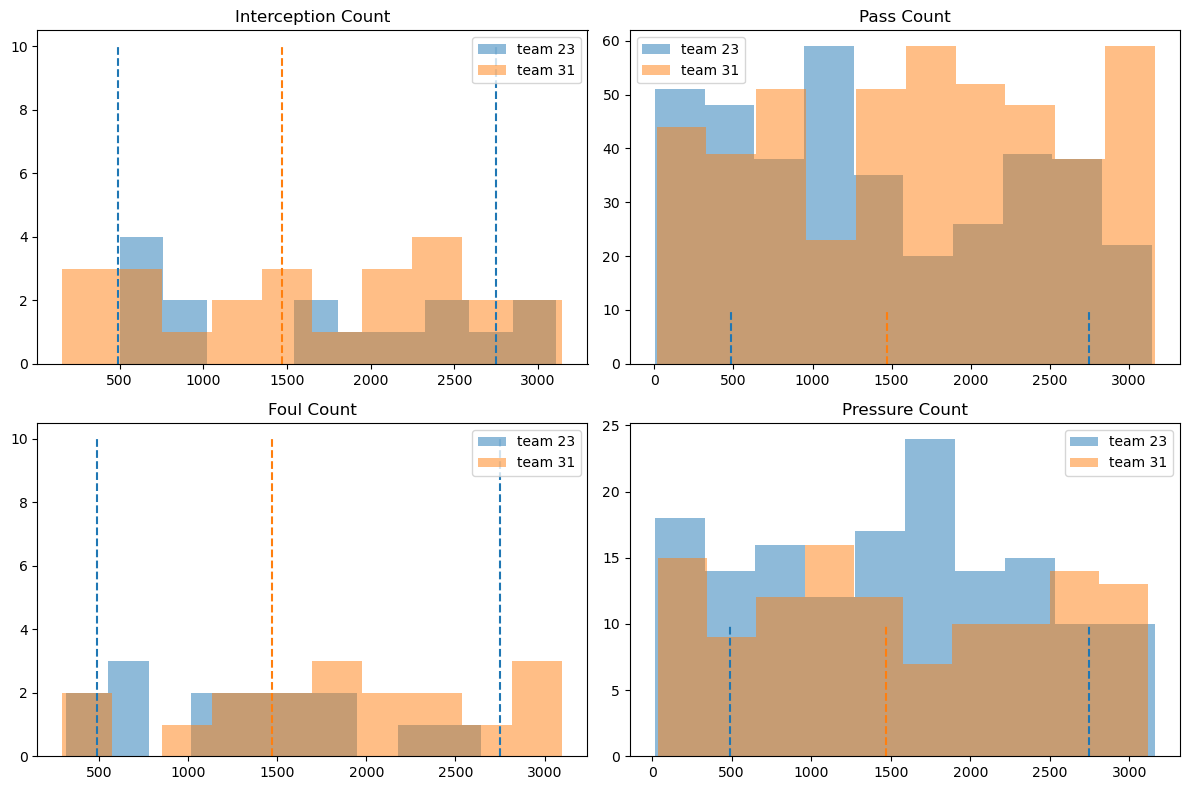

In [98]:
event_types = [
    {'type_id': 10, 'title': 'Interception Count'},
    {'type_id': 30, 'title': 'Pass Count'},
    {'type_id': 22, 'title': 'Foul Count'},
    {'type_id': 17, 'title': 'Pressure Count'},
]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()  # Flatten to make indexing easier

for i, event in enumerate(event_types):
    type_id = event['type_id']
    title = event['title']

    idx_team23 = df_matches[(df_matches['type.id'] == type_id) & (df_matches['team.id'] == 23)].index
    idx_team31 = df_matches[(df_matches['type.id'] == type_id) & (df_matches['team.id'] == 31)].index
    axs[i].hist(idx_team23, label='team 23', alpha=0.5)
    axs[i].hist(idx_team31, label='team 31', alpha=0.5)
    axs[i].vlines(goal_rowIndex, ymin=0, ymax=10, color=['C0', 'C1', 'C0'], linestyles='--')
    axs[i].set_title(title)
    axs[i].legend()
plt.tight_layout()
plt.show()


# panetrating pass; find the coordinates. 
# possession (especially the position of the possession. forward third, backward third), momentum, formation/tactic changes. pressing internsity. 
# Survival analysis: survival time until the next goal (statistical, use in the end.)
# RNN: RNN analysis -- process sequential data. feed each pass data into neural network. 
# evaluate the weight. non-linear data. Hazard function (risk until next goal).
# sequential matrix.